# IBSR Summary
*   Accuracy: ~97.5%, Loss: ~6%
*   Wavelets: Haar
*   Model Configurations: config2, config4, config16
*   Best Configurations Used: activation, activation2, activation3 = 'relu', 'relu', tfa.activations.mish
*   Non separable 2D conv. outperforms separable 2D conv.
*   DWT Pooling
*   batch_size = 2
*   epoch=10
*   256x256 input

# NFBS Summary:



# Installing Dependencies


In [ ]:
!pip install tensorflow-wavelets
!pip install keras-rl2
!pip install tensorflow_addons

# Installing WaveTF library
!git clone https://github.com/fversaci/WaveTF.git
%cd WaveTF
!pip install .
%cd ..

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 7.4 MB/s eta 0:00:00
Cloning into 'WaveTF'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 111 (delta 64), reused 89 (delta 44), pack-reused 0
Receiving objects: 100% (111/111), 37.88 KiB | 625.00 KiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/WaveTF
Processing /content/WaveTF
  Preparing metadata (setup.py) ... done
  Created wheel for WaveTF: filename=WaveTF-0.1-py3-none-any.whl size=25262 sha256=5dd15f4a34dfcb11227f66f9285379c1e068d65f20bde17a2147c9654807490b
  Stored in directory: /tmp/pip-ephem-wheel-cache-xk3ry2g8/wheels/57/8b/07/c0e602371c18b795f7156971d802abb39f244bd03197b4e9ea
Successfully built WaveTF
/content


# Importing Libraries

In [ ]:
import os
import random
import cv2
import numpy as np
import nibabel as nib
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# IBSR Dataset Preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/IBSR_nifti_stripped

/content/drive/.shortcut-targets-by-id/1lOtZFcHA8hbsluikXpfm0RmbuJlfaqu2/IBSR_nifti_stripped


In [ ]:
ls

anita_1.nii  IBSR_04/  IBSR_08/  IBSR_12/  IBSR_16/  mini_lucid_tf2/   wunet.h5
IBSR_01/     IBSR_05/  IBSR_09/  IBSR_13/  IBSR_17/  model_config2.h5  XIBSRsag.npy
IBSR_02/     IBSR_06/  IBSR_10/  IBSR_14/  IBSR_18/  README.txt        YIBSRsag.npy
IBSR_03/     IBSR_07/  IBSR_11/  IBSR_15/  logs/     vnet.pt


In [ ]:
lst = [i for i in range(125)]
test_list = random.sample(range(0, 125), 25)
train_list = [i for i in lst if i not in test_list]
train_list

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 51,
 52,
 55,
 56,
 57,
 60,
 61,
 62,
 63,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 99,
 100,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 124]

In [ ]:
Droot = '/content/drive/MyDrive/IBSR_nifti_stripped'

import os
dirs = os.listdir(Droot)
dirs

dirs = [_ for _ in dirs if os.path.isdir(os.path.join(Droot,_))]
dirs

h1 = '_ana.nii.gz'
h2 = '_ana_brainmask.nii.gz'
h3 = '_ana_strip.nii.gz'

global vimgs, vimgs_mask
vimgs = [os.path.join(Droot,d,_) for d in dirs for _ in os.listdir(os.path.join(Droot,d)) if _.endswith(h1) and _.startswith('I') and len(_)<19]
vimgs_mask = [os.path.join(Droot,d,_) for d in dirs for _ in os.listdir(os.path.join(Droot,d)) if _.endswith(h2) and _.startswith('I')]# and len(_)<16]
#vimgs_strip = [os.path.join(Droot,d,_) for d in dirs for _ in os.listdir(os.path.join(Droot,d)) if _.endswith(h3) and _.startswith('I')]# and len(_)<16]
vimgs

['/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_14/IBSR_14_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_12/IBSR_12_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_10/IBSR_10_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_11/IBSR_11_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_18/IBSR_18_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_16/IBSR_16_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_15/IBSR_15_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_13/IBSR_13_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_17/IBSR_17_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_09/IBSR_09_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_07/IBSR_07_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_04/IBSR_04_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_02/IBSR_02_ana.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_st

In [ ]:
vimgs_mask

['/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_14/IBSR_14_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_12/IBSR_12_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_10/IBSR_10_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_11/IBSR_11_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_18/IBSR_18_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_16/IBSR_16_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_15/IBSR_15_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_13/IBSR_13_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_17/IBSR_17_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_09/IBSR_09_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_07/IBSR_07_ana_brainmask.nii.gz',
 '/content/drive/MyDrive/IBSR_nifti_stripped/IBSR_04/IBSR_04_ana_brainmask.n

In [ ]:
data_paths = [(_1,_2) for _1,_2 in zip(vimgs,vimgs_mask)]
data_paths

del Droot, vimgs, vimgs_mask, h1, h2, dirs

data_paths

import nibabel as nib
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os

data = [(nib.load(_[0]).get_fdata(), nib.load(_[1]).get_fdata()) for _ in data_paths]
type(data)
# print(data.shape)

import numpy as np
vimgs = np.array([_[0] for _ in data])
vimgs.shape

vimgs_mask = np.array([_[1] for _ in data])
vimgs_mask.shape

(18, 256, 128, 256, 1)

In [ ]:
vimgs.shape

(18, 256, 256, 128, 1)

In [ ]:
# FIX orientation of volumetric images
vimgs_ = np.zeros(vimgs_mask.shape, dtype=np.uint8)
vimgs_.shape
from scipy.ndimage import rotate
A = vimgs
for idx in range(vimgs.shape[0]):
    a = A[idx]

    #Align orientation of images with masks
    a = rotate(a, 180, axes=(1, 0), reshape=False)
    print(a.shape, 'rot1')
    a = rotate(a, -90, axes=(1, 2), reshape=True)
    print(a.shape, 'rot2')

    vimgs_[idx] = a
vimgs_.shape

(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2
(256, 256, 128, 1) rot1
(256, 128, 256, 1) rot2


(18, 256, 128, 256, 1)

volume #5, slice #20


(<Axes: title={'center': 'mask'}>,
 Text(0.5, 1.0, 'mask'))

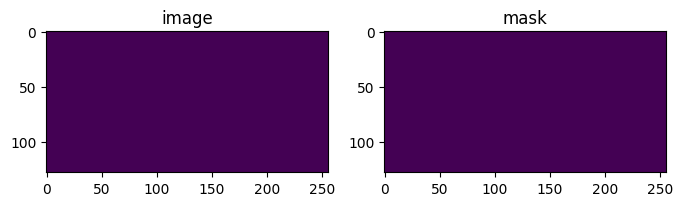

In [ ]:
import random
k= random.randint(0,17)
i= random.randint(0,vimgs_.shape[1])
print(f"volume #{k}, slice #{i}")
plt.figure(figsize=(8,4))
plt.subplot(121), plt.imshow(vimgs_[k,i,:,:,0]), plt.title('image')
plt.subplot(122), plt.imshow(vimgs_mask[k,i,:,:,0]), plt.title('mask')

In [ ]:
# FIX SIZE: MAKE CUBE NxNxN
import tensorflow as tf
vimgs__ = np.zeros((18, 256, 256, 256, 1), dtype=np.uint8)
for k in range(18):
    _ = tf.image.resize(
        vimgs_[k],
        size=[256,256],
        method='bilinear',
        preserve_aspect_ratio=False,
        antialias=False,
        name=None
        )
    vimgs__[k]=_
print(vimgs__.shape)
del vimgs
vimgs=vimgs__
del vimgs__
vimgs.shape

(18, 256, 256, 256, 1)


(18, 256, 256, 256, 1)

In [ ]:
# Mask FIX SIZE: MAKE CUBE NxNxN
import tensorflow as tf
vimgs_mask__ = np.zeros((18, 256, 256, 256, 1), dtype=np.uint8)
for k in range(18):
    _ = tf.image.resize(
        vimgs_mask[k],
        size=[256,256],
        method='bilinear',
        preserve_aspect_ratio=False,
        antialias=False,
        name=None
        )
    vimgs_mask__[k]=_
print(vimgs_mask__.shape)
del vimgs_mask
vimgs_mask = vimgs_mask__
del vimgs_mask__

(18, 256, 256, 256, 1)


volume #8, slice #34


(<Axes: >, <matplotlib.image.AxesImage at 0x7fa0c62e4100>)

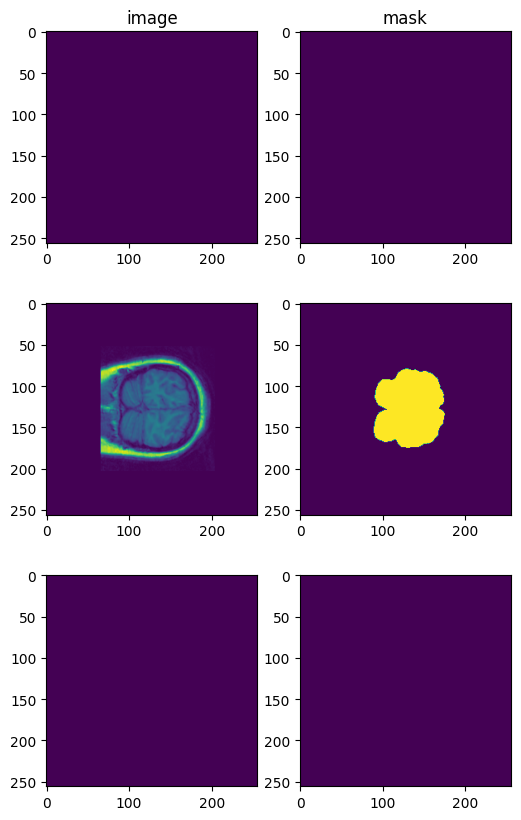

In [ ]:
import random
v= random.randint(0,17)
i, j, k = random.randint(0,vimgs_.shape[1]), random.randint(0,vimgs_.shape[2]), random.randint(0,vimgs_.shape[3])
print(f"volume #{k}, slice #{i}")
plt.figure(figsize=(6,10))
plt.subplot(321), plt.imshow(vimgs[v,i,:,:,0]), plt.title('image')
plt.subplot(322), plt.imshow(vimgs_mask[v,i,:,:,0]), plt.title('mask')
plt.subplot(323), plt.imshow(vimgs[v,:,j,:,0])
plt.subplot(324), plt.imshow(vimgs_mask[v,:,j,:,0])
plt.subplot(325), plt.imshow(vimgs[v,:,:,k,0])
plt.subplot(326), plt.imshow(vimgs_mask[v,:,:,k,0])

In [ ]:
whos

Variable     Type          Data/Info
------------------------------------
A            ndarray       18x256x256x128x1: 150994944 elems, type `float64`, 1207959552 bytes (1152.0 Mb)
DWT          module        <module 'tensorflow_wavel<...>_wavelets/Layers/DWT.py'>
a            ndarray       256x128x256x1: 8388608 elems, type `float64`, 67108864 bytes (64.0 Mb)
cv2          module        <module 'cv2' from '/usr/<...>ackages/cv2/__init__.py'>
data         list          n=18
data_paths   list          n=18
drive        module        <module 'google.colab.dri<...>s/google/colab/drive.py'>
h3           str           _ana_strip.nii.gz
i            int           34
idx          int           17
j            int           42
k            int           8
keras        LazyLoader    <LazyLoader keras.api._v2.keras as keras>
lst          list          n=125
ndi          module        <module 'scipy.ndimage' f<...>ipy/ndimage/__init__.py'>
nib          module        <module 'nibabel' from '/<...>ge

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

def XYtrain_unit(uid):
    global vimgs, vimgs_mask
    vx_ = vimgs[uid]
    vy_ = vimgs_mask[uid]
    vx_.shape

    X_train = np.zeros((vx_.shape[1], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((vx_.shape[1], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    X_train.shape
    for slic_id in range(vx_.shape[1]):
       _x = ndi.rotate(vx_[slic_id,:,:,0],90)
       _x = np.fliplr(_x)
       _y = np.uint8(ndi.rotate(vy_[slic_id,:,:,0].T,180))

       X_train[slic_id] = _x.reshape((_x.shape[0],_x.shape[1],1))
       Y_train[slic_id] = _y.reshape((_y.shape[0],_y.shape[1],1))

    return X_train, Y_train

XY = []
for uid in range(vimgs.shape[0]):
    XY.append(XYtrain_unit(uid))

type(XY[0][0])
XY[0][0].shape
XY[0][1].shape

X = XY[0][0]
Y = XY[0][1]
for _ in XY[1:]:
    X = np.concatenate([X, _[0]])
    Y = np.concatenate([Y, _[1]])
print(X.shape)
X.shape==Y.shape

(4608, 256, 256, 1)


True

In [ ]:
%cd  '/content'

/content


In [ ]:
with open('XIBSRsag.npy', 'wb') as f:
    np.save(f, X)
with open('YIBSRsag.npy', 'wb') as f:
    np.save(f, Y)

In [ ]:
whos


Variable       Type              Data/Info
------------------------------------------
A              ndarray           18x256x256x128x1: 150994944 elems, type `float64`, 1207959552 bytes (1152.0 Mb)
DWT            module            <module 'tensorflow_wavel<...>_wavelets/Layers/DWT.py'>
IMG_CHANNELS   int               1
IMG_HEIGHT     int               256
IMG_WIDTH      int               256
X              ndarray           4608x256x256x1: 301989888 elems, type `uint8`, 301989888 bytes (288.0 Mb)
XY             list              n=18
XYtrain_unit   function          <function XYtrain_unit at 0x7f9fee23f9a0>
Y              ndarray           4608x256x256x1: 301989888 elems, type `bool`, 301989888 bytes (288.0 Mb)
a              ndarray           256x128x256x1: 8388608 elems, type `float64`, 67108864 bytes (64.0 Mb)
cv2            module            <module 'cv2' from '/usr/<...>ackages/cv2/__init__.py'>
data           list              n=18
data_paths     list              n=18
drive   

In [ ]:
del X, Y

In [ ]:
import numpy as np
with open('XIBSRsag.npy', 'rb') as f:
    X = np.load(f)
with open('YIBSRsag.npy', 'rb') as f:
    Y = np.load(f)

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
p = int(16*256)

X_train, Y_train = X[:p,:,:,:], Y[:p,:,:,:]
X_test, Y_test = X[p:,:,:,:], Y[p:,:,:,:] # note y_test is to check accuracy

X_train.shape==Y_train.shape
X_train.shape

X_test.shape=Y_test.shape
X_test.shape

(512, 256, 256, 1)

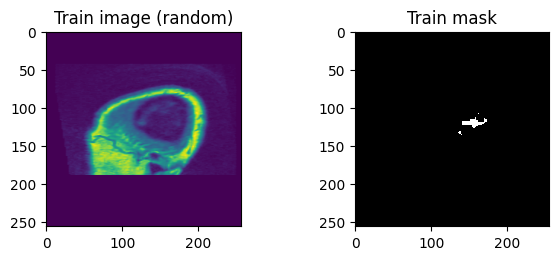

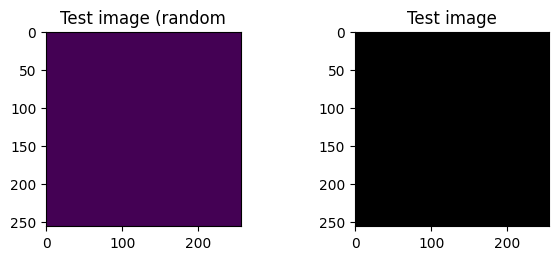

In [ ]:
import random
seed = 42
np.random.seed = seed

image_x = random.randint(0, X_train.shape[0])
plt.subplot(221), plt.imshow(X_train[image_x]), plt.title('Train image (random)')
plt.subplot(222), imshow(np.squeeze(Y_train[image_x])), plt.title('Train mask')
plt.show()

image_x_test = random.randint(0, X_test.shape[0])
plt.subplot(223), plt.imshow(X_train[image_x_test]),plt.title('Test image (random')
plt.subplot(224), imshow(np.squeeze(Y_train[image_x_test])),plt.title('Test image')
plt.show()

In [ ]:
#Build the model
#inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

T_resize = tf.keras.Sequential(
    [
        tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        tf.keras.layers.Resizing(
            height=256,
            width=256,
            interpolation='bilinear',
            crop_to_aspect_ratio=False
        )
    ])

#model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
T_resize.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 256, 256, 1)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(Y_train.shape)
X_train.shape

(4096, 256, 256, 1)


(4096, 256, 256, 1)

In [ ]:
X_train = T_resize.predict(X_train)
Y_train = T_resize.predict(Y_train)
print(X_train.shape==Y_train.shape)
X_train.shape

128/128 [==============================] - 0s 2ms/step
True


(4096, 256, 256, 1)

In [ ]:
X_test = T_resize.predict(X_test)
Y_test = T_resize.predict(Y_test)
print(X_test.shape==Y_test.shape)

X_test.shape

16/16 [==============================] - 0s 2ms/step
True


(512, 256, 256, 1)

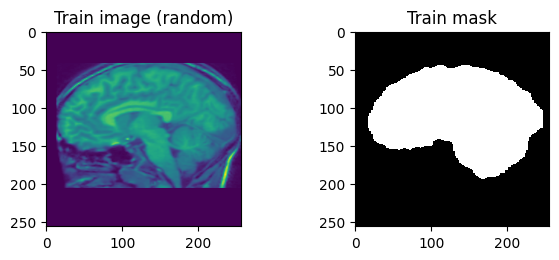

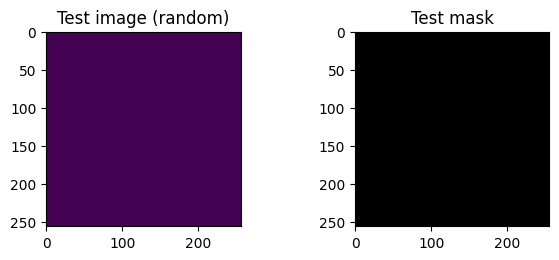

In [ ]:
import random
seed = 42
np.random.seed = seed


image_x = random.randint(0, X_train.shape[0])
plt.subplot(221), plt.imshow(X_train[image_x]), plt.title('Train image (random)')
plt.subplot(222), imshow(np.squeeze(Y_train[image_x])), plt.title('Train mask')
plt.show()

image_x_test = random.randint(0, X_test.shape[0])
plt.subplot(223), plt.imshow(X_train[image_x_test]),plt.title('Test image (random)')
plt.subplot(224), imshow(np.squeeze(Y_train[image_x_test])),plt.title('Test mask')
plt.show()

# NFBS Dataset Precprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/NFBS_Dataset

/content/drive/.shortcut-targets-by-id/1aWjHT_sUZg_PB4WDujGAZFpZX-JGt568/NFBS_Dataset


In [ ]:
Droot = '/content/drive/MyDrive/NFBS_Dataset'

In [ ]:
dirs = os.listdir(Droot)
dirs

['A00063589',
 'A00063368',
 'A00062917',
 'A00063008',
 'A00063103',
 'A00062351',
 'A00062934',
 'A00064081',
 'A00063326',
 'A00062942',
 'A00061711',
 'A00061806',
 'A00061276',
 'A00062288',
 'A00062266',
 'A00062210',
 'A00062248',
 'A00061709',
 'A00061387',
 'A00062282',
 'A00060372',
 'A00060430',
 'A00061204',
 'A00060516',
 'A00060632',
 'A00060407',
 'A00060480',
 'A00060848',
 'A00060925',
 'A00060471',
 'A00060279',
 'A00059845',
 'A00059346',
 'A00060259',
 'A00060093',
 'A00060006',
 'A00060169',
 'A00059428',
 'A00059911',
 'A00059756',
 'A00058218',
 'A00058214',
 'A00059344',
 'A00057965',
 'A00057808',
 'A00058552',
 'A00058667',
 'A00058503',
 'A00058952',
 'A00058999',
 'A00057444',
 'A00057235',
 'A00057005',
 'A00057786',
 'A00057203',
 'A00057182',
 'A00056898',
 'A00057035',
 'A00056949',
 'A00057372',
 'A00055447',
 'A00055763',
 'A00055542',
 'A00056556',
 'A00056306',
 'A00056097',
 'A00055806',
 'A00056627',
 'A00055738',
 'A00056452',
 'A00054914',
 'A000

In [ ]:
dirs = [_ for _ in dirs if os.path.isdir(os.path.join(Droot,_)) and _.startswith('A')]
dirs
len(dirs)

125

In [ ]:
h1 = 'NFB3_T1w_brain.nii.gz'
h2 = 'NFB3_T1w_brainmask.nii.gz'
h3 = 'NFB3_T1w.nii.gz'

In [ ]:
global vimgs, vimgs_mask
vimgs = [os.path.join(Droot,d,_) for d in dirs for _ in os.listdir(os.path.join(Droot,d)) if _.endswith(h1)]
vimgs_mask = [os.path.join(Droot,d,_) for d in dirs for _ in os.listdir(os.path.join(Droot,d)) if _.endswith(h2)]
print(len(vimgs))
vimgs

125


['/content/drive/MyDrive/NFBS_Dataset/A00063589/sub-A00063589_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063368/sub-A00063368_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062917/sub-A00062917_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063008/sub-A00063008_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063103/sub-A00063103_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062351/sub-A00062351_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062934/sub-A00062934_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00064081/sub-A00064081_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063326/sub-A00063326_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062942/sub-A00062942_ses-NFB3_T1w_brain.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00061711/sub-A00061711_ses-NFB3_T1w_brain.nii.gz',
 '/content

In [ ]:
print(len(vimgs_mask))
vimgs_mask

125


['/content/drive/MyDrive/NFBS_Dataset/A00063589/sub-A00063589_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063368/sub-A00063368_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062917/sub-A00062917_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063008/sub-A00063008_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063103/sub-A00063103_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062351/sub-A00062351_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062934/sub-A00062934_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00064081/sub-A00064081_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063326/sub-A00063326_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062942/sub-A00062942_ses-NFB3_T1w_brainmask.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00061711/sub-A0006171

In [ ]:
vimgs_t1 = [os.path.join(Droot,d,_) for d in dirs for _ in os.listdir(os.path.join(Droot,d)) if _.endswith(h3)]
print(len(vimgs_t1))
vimgs_t1

125


['/content/drive/MyDrive/NFBS_Dataset/A00063589/sub-A00063589_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063368/sub-A00063368_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062917/sub-A00062917_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063008/sub-A00063008_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063103/sub-A00063103_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062351/sub-A00062351_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062934/sub-A00062934_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00064081/sub-A00064081_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00063326/sub-A00063326_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00062942/sub-A00062942_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00061711/sub-A00061711_ses-NFB3_T1w.nii.gz',
 '/content/drive/MyDrive/NFBS_Dataset/A00061806/sub-A00061806_ses-NFB3_T1w.n

In [ ]:
data_paths = [(_1,_2,_3) for _1,_2,_3 in zip(vimgs,vimgs_mask,vimgs_t1)]
data_paths

del Droot, vimgs, vimgs_mask, vimgs_t1, h1, h2, h3, dirs

data_paths

import nibabel as nib
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os

data = [(nib.load(_[0]).get_fdata(), nib.load(_[1]).get_fdata()) for _ in data_paths]
type(data)

import numpy as np
vimgs = np.array([_[0] for _ in data])
vimgs.shape

vimgs_mask = np.array([_[1] for _ in data])
vimgs_mask.shape

In [ ]:
vimgs = np.reshape(vimgs,(vimgs.shape[0],vimgs.shape[1],vimgs.shape[2],vimgs.shape[3],1))
vimgs_mask = np.reshape(vimgs_mask,(vimgs_mask.shape[0],vimgs_mask.shape[1],vimgs_mask.shape[2],vimgs_mask.shape[3],1))
print(vimgs_mask.shape==vimgs.shape) # mask shape == vimg shape
vimgs.shape

In [ ]:
print(vimgs_mask.shape == vimgs.shape)
vimgs_mask.shape

In [ ]:
IMG_WIDTH = 192
IMG_HEIGHT = 256
IMG_CHANNELS = 1

def XYtrain_unit(k):
    global vimgs, vimgs_mask
    vx_ = vimgs[k]
    vy_ = vimgs_mask[k]
    vx_.shape

    X_train = np.zeros((vx_.shape[1], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((vx_.shape[1], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    X_train.shape
    for slic in range(vx_.shape[1]):
       _x = vx_[slic,:,:,0]
       _y = np.uint8(vy_[slic,:,:,0])

       X_train[slic] = _x.reshape((_x.shape[0],_x.shape[1],1))
       Y_train[slic] = _y.reshape((_y.shape[0],_y.shape[1],1))

    return X_train, Y_train

XY = []
for k in range(vimgs.shape[0]):
    XY.append(XYtrain_unit(k))

print(len(XY))

In [ ]:
print(type(XY[0][0]))
print(XY[0][0].shape == XY[0][1].shape)
XY[0][1].shape

In [ ]:
X = XY[0][0]
Y = XY[0][1]
for _ in XY[1:]:
    X = np.concatenate([X, _[0]])
    Y = np.concatenate([Y, _[1]])
X.shape==Y.shape

In [ ]:
import pickle
with open('NFBSXTr', 'wb') as file:
    pickle.dump(X, file)
del file
with open('NFBSYTr', 'wb') as file:
    pickle.dump(Y, file)
del file

In [ ]:
#LOAD
import pickle
with open('NFBSXTr', 'rb') as file:
    X = pickle.load(file)
del file
with open('NFBSYTr', 'rb') as file:
    Y = pickle.load(file)
del file

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

print(X_train.shape==Y_train.shape)
X_train.shape

In [ ]:
print(X_test.shape==Y_test.shape)
X_test.shape

In [ ]:
import random
seed = 42
np.random.seed = seed

image_x = random.randint(0, X_train.shape[0])
plt.subplot(221), plt.imshow(X_train[image_x]), plt.title('Train image (random)')
plt.subplot(222), imshow(np.squeeze(Y_train[image_x])), plt.title('Train mask')
plt.show()

image_x_test = random.randint(0, X_test.shape[0])
plt.subplot(223), plt.imshow(X_train[image_x_test]),plt.title('Test image (random')
plt.subplot(224), imshow(np.squeeze(Y_train[image_x_test])),plt.title('Test image')
plt.show()

In [ ]:
X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)
print(type(X_train)==type(Y_train))
type(X_train)

In [ ]:
adapt(X_train, batch_size=None, steps=None)

In [ ]:
whos

# Losses

$Dice=\frac{2*Intersection}{Union+Intersection}$

In [ ]:
def Dice(P,T):
    print(P,T)
    #print(logits, y)
    #o = tf.ones((256,256,1))
    #P = tf.where(P, o * 1.0, o * 0.0)
    I=tf.math.abs(tf.reduce_sum(tf.math.multiply(P,T)))
    U=tf.math.abs(tf.reduce_sum(T+P-(T*P)))
        #tf.math.subtract(tf.math.add(logits,y),tf.math.multiply(logits,y)))
    dice=(2*I)/(U+I)#tf.math.subtract(tf.constant(1.0, dtype=tf.float32),tf.math.divide(inter,union))
    return 1-dice

$IoU'=\frac{|T*P|}{|T+P-(T*P)|}=\frac{I}{U}$

In [ ]:
def IoU(P,T):
    #print(logits, y)
    #o = tf.ones((256,192,1))
    #P = tf.where(P, o * 1.0, o * 0.0)
    I=tf.math.abs(tf.reduce_sum(tf.math.multiply(P,T)))
    U=tf.math.abs(tf.reduce_sum(T+P-(T*P)))
        #tf.math.subtract(tf.math.add(logits,y),tf.math.multiply(logits,y)))
    iou=(I+1)/(U+1)#tf.math.subtract(tf.constant(1.0, dtype=tf.float32),tf.math.divide(inter,union))
    return (1-iou)/(1+iou)

# DNN Model Configs

In [ ]:
# Model configuration options
# of trainable filter configs. for DWTUnet
config = {
    'config2':(2,2,2,2,2,2),
    'config4':(4,4,4,4,4,4),
    'config8':(8,8,8,8,8,8),
    'config16':(16,16,16,16,16,16),
    'config32':(32,32,32,32,32,32),
    'config64':(64,64,64,64,64,64),
    'config42':(4,2,2,2,2,2),
    'config82':(8,2,2,2,2,2),
    'config162':(16,2,2,2,2,2),
    'config322':(32,2,2,2,2,2),
    'config642':(64,2,2,2,2,2),
    'config84':(8,4,4,4,4,4),
    'config164':(16,4,4,4,4,4),
    'config322':(32,4,4,4,4,4),
    'config644':(64,4,4,4,4,4),
    'config168':(16,8,8,8,8,8),
    'config328':(32,8,8,8,8,8),
    'config648':(64,8,8,8,8,8),
    'config3216':(32,16,16,16,16,16),
    'config6416':(64,16,16,16,16,16),
    'config6432':(64,32,32,32,32,32),
    'config132':(1,2,4,8,16,32),
    'config264':(2,4,8,16,32,64),
    'config4128':(4,8,16,32,64,128),
    'config8256':(8,16,32,64,128,256),
    }

In [ ]:
##CONFIG: Trainable filters
f,a,b,c,d,e=config['config2']
global wave
wave = 'haar'

In [ ]:
def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.
        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.
        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        # we build a loss function that maximizes the activation
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                if loss_value <= K.epsilon():
                    return None

            # Calculate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

In [ ]:
import tensorflow_wavelets.Layers.DWT as DWT
#import keras

## DWT
class dwt(tf.keras.layers.Layer):
  """DWT Layer"""
  def __init__(self):
    super(dwt, self).__init__()
    global wave
    self.dwt = DWT.DWT(name=wave,concat=0)

  def call(self, x):
    return self.dwt(x)

## IDWT
class idwt(tf.keras.layers.Layer):
  """IDWT Layer"""
  def __init__(self):
    super(idwt, self).__init__()
    global wave
    self.idwt = DWT.IDWT(name=wave,splitted=1)

  def call(self, x):
    return self.idwt(x)

In [ ]:
## Pooling layer
import tensorflow as tf
import tensorflow_wavelets.Layers.DWT as DWT
#from Mish import Mish

class Pooling(tf.keras.layers.Layer):
    '''DWT Pooling Layer: keep Low freq band only
          #separableConv2D
          #Mish'''
    def __init__(self, Ψ='', **kwargs):
        super(Pooling, self).__init__(**kwargs)
        self.supports_masking = True
        self.Ψ = 'haar'
        self.dwt = DWT.DWT(name=self.Ψ, concat=0)

    def call(self, inputs):
        """inputs -> wave0 -> wave1 #
        !!-> wave2 -> wave0_cap(inverse)"""
        chans = inputs.shape[3]
        wave0 = inputs #L0
        wave1 = self.dwt(wave0) #L1

        #wave2 = WaveTFFactory.build(wave_kern)(wave1[:,:,:,:chans])
        #inv_wave0 = WaveTFFactory().build(wave_kern, inverse = True)(wave2)

        #pool = DWT.DWT(name=wave,concat=0)(inputs)
        return wave1[:,:,:,:chans]
        #return tf.keras.layers.MaxPooling2D((2, 2))(inputs)
        #return tf.keras.layers.AveragePooling2D((2, 2))(inputs)

In [ ]:
activation= 'relu'
#activation = tfa.activations.mish

#activation2='sigmoid'
activation2='relu'

activation3='sigmoid'
#activation3='softmax' #bad perf.
activation3 = tfa.activations.mish


activation, activation2, activation3 = 'relu', 'relu', tfa.activations.mish #BEST CONFIG. ***

# Model

In [ ]:
class MRImages_NFBS(tf.keras.utils.Sequence):
    def __init__(self, parent_dir, view=None):
        self.parent_dir = parent_dir
        self.view = view
        self.files = os.listdir(parent_dir)
        # self.samples = samples

    def __len__(self):
      # 100 images for training rest 25 image used for testing
        return 100

    # returns single slices of frontal view
    def frontal_view_imgs(self, data):
      list_frontal_view_imgs = []
      for i in range(256):
        im_slice = data[i,:,:]
        # im_resized = im_slice
        im_resized = cv2.resize(im_slice, (256, 256))
        del im_slice
        list_frontal_view_imgs.append(np.expand_dims(im_resized, -1))

      list_frontal_view_imgs = np.array(list_frontal_view_imgs)
      return list_frontal_view_imgs

    # returns single slices of side view
    def side_view_imgs(self, data):
      list_side_view_imgs = []
      for i in range(192):

        im_slice = data[:,:,i]

        # im_resized = im_slice
        im_resized = cv2.resize(im_slice, (256, 256))
        del im_slice

        list_side_view_imgs.append(np.expand_dims(im_resized, -1))

      list_side_view_imgs = np.array(list_side_view_imgs)
      return list_side_view_imgs

    # returns single slices of top view
    def top_view_imgs(self, data):
      list_top_view_imgs = []
      for i in range(256):
          im_slice = data[:, i, :]
          # im_resized = im_slice
          im_resized =  cv2.resize(im_slice, (256, 256))
          list_top_view_imgs.append(np.expand_dims(im_resized, -1))

      list_top_view_imgs = np.array(list_top_view_imgs)
      return list_top_view_imgs

    # returns i_th image from ISBR w.r.t view
    def __getitem__(self, i):
        # print(self.files)
        folder_path = os.listdir(os.path.join(self.parent_dir, self.files[i]))
        folder_path.sort()

        img_path = os.path.join(self.parent_dir, self.files[i], folder_path[0])
        mask_path = os.path.join(self.parent_dir, self.files[i], folder_path[2])

        img = nib.load(img_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        img = np.squeeze(img)
        mask = np.squeeze(mask)
        # img = zoom(img, (0.5, 0.5, 128/192))
        # mask = zoom(mask, (0.5, 1, 128/192))


        if self.view == "top":
          t_images = self.top_view_imgs(img)
          t_mask = self.top_view_imgs(mask)
          return t_images, t_mask

        elif self.view == "side":
          s_images = self.side_view_imgs(img)
          s_mask = self.side_view_imgs(mask)

          return s_images, s_mask


        elif self.view == "frontal":
          f_images = self.frontal_view_imgs(img)
          f_mask = self.frontal_view_imgs(mask)

          return f_images, f_mask

In [ ]:
# Type 1

#from keras.engine.training import h5py
inputs = tf.keras.layers.Input((256, 256, 1))
#inputs = tf.keras.layers.Input((256, 256, 1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#inputs = tf.keras.layers.Input((256, 192, 1))
# inputs_resiz  = tf.keras.layers.Resizing(
#                 height=256,
#                 width=256,
#                 interpolation='bilinear',
#                 crop_to_aspect_ratio=False
#             )(inputs)
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs_resiz)


"""
# DWT
Ψ = 'haar'
c = 1
w1 = WaveTFFactory.build(Ψ)(s)
l1, h1 = w1[:,:,:,:c], w1[:,:,:,c:]
#
w2 = WaveTFFactory.build(Ψ)(l1)
l2, h2 = w2[:,:,:,:c], w2[:,:,:,c:]
#
w3 = WaveTFFactory.build(Ψ)(l2)
l3, h3 = w3[:,:,:,:c], w3[:,:,:,c:]
#
w4 = WaveTFFactory.build(Ψ)(l3)
l4, h4 = w4[:,:,:,:c], w4[:,:,:,c:]
#
w5 = WaveTFFactory.build(Ψ)(l4)
l5, h5 = w5[:,:,:,:c], w5[:,:,:,c:]
#
w6 = WaveTFFactory.build(Ψ)(l5)
l6, h6 = w6[:,:,:,:c], w6[:,:,:,c:]
"""

# DWT
#wave = 'haar'
#dwt1 = DWT.DWT(name=wave,concat=0)
#dwt2 = DWT.DWT(name=wave,concat=0)
#dwt3 = DWT.DWT(name=wave,concat=0)
#dwt4 = DWT.DWT(name=wave,concat=0)
#dwt5 = DWT.DWT(name=wave,concat=0)
#dwt6 = DWT.DWT(name=wave,concat=0)
#idwt1 = DWT.IDWT(wavelet_name=wave, splited = 1)
#idwt2 = DWT.IDWT(wavelet_name=wave, splited = 1)
#idwt3 = DWT.IDWT(wavelet_name=wave, splited = 1)
#idwt4 = DWT.IDWT(wavelet_name=wave, splited = 1)
#idwt5 = DWT.IDWT(wavelet_name=wave, splited = 1)
#idwt6 = DWT.IDWT(wavelet_name=wave, splited = 1)

#idwt  = DWT.IDWT(wavelet_name=wave, splited = 1)
chans=2
s0 = tf.keras.layers.Conv2D(chans, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s) # 256
s0 = Pooling()(s0) #128 128 16
print(s.shape)
print(s0.shape)
c = 1
l = dwt()(s0)


l1 = l[:,:,:,:chans]
h1 = l[:,:,:,chans:]
# print(l1.shape)
#
l = dwt()(l1)
l2 = l[:,:,:,:chans]
h2 = l[:,:,:,chans:]
#
l = dwt()(l2)
l3 = l[:,:,:,:chans]
h3 = l[:,:,:,chans:]
#
l = dwt()(l3)
l4 = l[:,:,:,:chans]
h4 = l[:,:,:,chans:]
#
l = dwt()(l4)
l5 = l[:,:,:,:chans]
h5 = l[:,:,:,chans:]
#
l = dwt()(l5)
l6 = l[:,:,:,:chans]
h6 = l[:,:,:,chans:]


xl1 = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l1)
xl1 = tf.keras.layers.Dropout(0.1)(xl1)
xl1_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl1)

xl1 = Pooling()(xl1_)

xl2 = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l2)
xl2 = tf.keras.layers.Dropout(0.1)(xl2)
xl2_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl2)
xl2 = tf.keras.layers.Concatenate()([xl1, xl2_])
xl2 = tf.keras.layers.Conv2D(a, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl2)
xl2 = Pooling()(xl2_)
#xl2a = tf.keras.layers.MaxPooling2D((2, 2))(Concatenate()([xl1_, xl2]))

xl3 = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l3)
xl3 = tf.keras.layers.Dropout(0.1)(xl3)
xl3_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl3)
xl3 = tf.keras.layers.Concatenate()([xl2, xl3_])
xl3 = tf.keras.layers.Conv2D(b, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl3)
xl3 = Pooling()(xl3)
#xl3 = tf.keras.layers.MaxPooling2D((2, 2))(xl3)
#xl3_ = tf.keras.layers.MaxPooling2D((2, 2))(Concatenate()([xl2_, xl3]))

xl4 = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l4)
xl4 = tf.keras.layers.Dropout(0.1)(xl4)
xl4_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl4)
xl4 = tf.keras.layers.Concatenate()([xl3, xl4_])
xl4 = tf.keras.layers.Conv2D(c, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl4)
xl4 = Pooling()(xl4)
#xl4_ = tf.keras.layers.MaxPooling2D((2, 2))(Concatenate()([xl3_, xl4]))

xl5 = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l5)
xl5 = tf.keras.layers.Dropout(0.1)(xl5)
xl5_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl5)
xl5 = tf.keras.layers.Concatenate()([xl4, xl5_])
xl5 = tf.keras.layers.Conv2D(d, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl5)
xl5 = Pooling()(xl5)
#xl5_ = tf.keras.layers.MaxPooling2D((2, 2))(Concatenate()([xl4_, xl5]))

xl6 = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l6)
xl6 = tf.keras.layers.Dropout(0.1)(xl6)
xl6_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl6)
xl6 = tf.keras.layers.Concatenate()([xl5, xl6_])
xl6 = tf.keras.layers.Conv2D(e, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl6)
xl6 = Pooling()(xl6)
#xl6_ = tf.keras.layers.MaxPooling2D((2, 2))(Concatenate()([xl5_, xl6]))

# floor------------
xl6 = tf.keras.layers.Conv2D(e, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl6)
xl6 = tf.keras.layers.Dropout(0.1)(xl6)
xl6 = tf.keras.layers.Conv2D(e, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl6)
#-----------------

## Decoder /Synthesis -----------------
xl7_ = tf.keras.layers.Conv2DTranspose(e, (2, 2), strides=(2, 2), padding='same')(xl6)
xl7_ = tf.keras.layers.Concatenate()([xl6_, xl7_])
xl7_ = tf.keras.layers.Conv2D(e, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl7_)
xl7_ = tf.keras.layers.Dropout(0.2)(xl7_)
xl7_ = tf.keras.layers.Conv2D(e, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl7_)
#one up pass, one branch pass
xl7 = xl7_

#xl7_ #up
#xl7_ pass
xl8_ = tf.keras.layers.Conv2DTranspose(d, (2, 2), strides=(2, 2), padding='same')(xl7_)
xl8_ = tf.keras.layers.Concatenate()([xl5_, xl8_])
xl8_ = tf.keras.layers.Conv2D(d, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl8_)
xl8_ = tf.keras.layers.Dropout(0.2)(xl8_)
xl8_ = tf.keras.layers.Conv2D(d, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl8_)
xl8 = xl8_



#xl8_ #up
#xl8_ pass
xl9_ = tf.keras.layers.Conv2DTranspose(c, (2, 2), strides=(2, 2), padding='same')(xl8_)
xl9_ = tf.keras.layers.Concatenate()([xl4_, xl9_])
xl9_ = tf.keras.layers.Conv2D(c, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl9_)
xl9_ = tf.keras.layers.Dropout(0.2)(xl9_)
xl9_ = tf.keras.layers.Conv2D(c, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xl9_)
xl9 = xl9_

#xl9_ #up
#xl9_ pass
xlA_ = tf.keras.layers.Conv2DTranspose(b, (2, 2), strides=(2, 2), padding='same')(xl9_)
xlA_ = tf.keras.layers.Concatenate()([xl3_, xlA_])
xlA_ = tf.keras.layers.Conv2D(b, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xlA_)
xlA_ = tf.keras.layers.Dropout(0.2)(xlA_)
xlA_ = tf.keras.layers.Conv2D(b, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xlA_)
xlA = xlA_

#xlA_ #up
#xlA_ pass
xlB_ = tf.keras.layers.Conv2DTranspose(a, (2, 2), strides=(2, 2), padding='same')(xlA_)
xlB_ = tf.keras.layers.Concatenate()([xl2_, xlB_])
xlB_ = tf.keras.layers.Conv2D(a, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xlB_)
xlB_ = tf.keras.layers.Dropout(0.2)(xlB_)
xlB_ = tf.keras.layers.Conv2D(a, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xlB_)
xlB = xlB_

#xlB_ #up
#xlB_ pass
xlC_ = tf.keras.layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(xlB_)
xlC_ = tf.keras.layers.Concatenate()([xl1_, xlC_])
xlC_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xlC_)
xlC_ = tf.keras.layers.Dropout(0.2)(xlC_)
xlC_ = tf.keras.layers.Conv2D(f, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(xlC_)
xlC = xlC_


xl7 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation2)(xl7)
xl8 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation2)(xl8)
xl9 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation2)(xl9)
xlA = tf.keras.layers.Conv2D(1, (1, 1), activation=activation2)(xlA)
xlB = tf.keras.layers.Conv2D(1, (1, 1), activation=activation2)(xlB)
xlC = tf.keras.layers.Conv2D(1, (1, 1), activation=activation2)(xlC)

"""

xl7 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(xl7)
xl8 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(xl8)
xl9 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(xl9)
xlA = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(xlA)
xlB = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(xlB)
xlC = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(xlC)
"""

"""
iw6 = Concatenate()([xl7,h6])
iw6 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(iw6)

#
iw5 = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(Concatenate()([xl8,iw6]))
iw5 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw5,h5]))
#
iw4 = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(Concatenate()([xl9,iw5]))
iw4 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw4,h4]))
#
iw3 = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(Concatenate()([xlA,iw4]))
iw3 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw3,h3]))
#
iw2 = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(Concatenate()([xlB,iw3]))
iw2 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw2,h2]))
#
iw1 = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(Concatenate()([xlC,iw2]))
iw1 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw1,h1]))
"""





iw6 = tf.keras.layers.Concatenate()([xl7,h6])
# print(iw6.shape)
iw6 = idwt()(iw6)
# print(iw6.shape)
#

iw5 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation3)(tf.keras.layers.Concatenate()([xl8,iw6]))
iw5 = idwt()(tf.keras.layers.Concatenate()([iw5,h5]))
#
iw4 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation3)(tf.keras.layers.Concatenate()([xl9,iw5]))
iw4 = idwt()(tf.keras.layers.Concatenate()([iw4,h4]))
#
iw3 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation3)(tf.keras.layers.Concatenate()([xlA,iw4]))
iw3 = idwt()(tf.keras.layers.Concatenate()([iw3,h3]))
#
iw2 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation3)(tf.keras.layers.Concatenate()([xlB,iw3]))
iw2 = idwt()(tf.keras.layers.Concatenate()([iw2,h2]))
#
iw1 = tf.keras.layers.Conv2D(1, (1, 1), activation=activation3)(tf.keras.layers.Concatenate()([xlC,iw2]))
iw1 = idwt()(tf.keras.layers.Concatenate()([iw1,h1]))



out = tf.keras.layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(tf.keras.layers.Concatenate()([s0,iw1]))
out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(out)










"""
#
iw5 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(Concatenate()([xl8,iw6]))
iw5 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw5,h5]))
#
iw4 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(Concatenate()([xl9,iw5]))
iw4 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw4,h4]))
#
iw3 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(Concatenate()([xlA,iw4]))
iw3 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw3,h3]))
#
iw2 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(Concatenate()([xlB,iw3]))
iw2 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw2,h2]))
#
iw1 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(Concatenate()([xlC,iw2]))
iw1 = WaveTFFactory().build(Ψ, dim=2, inverse=True)(Concatenate()([iw1,h1]))

"""

# out_resiz  = tf.keras.layers.Resizing(
#                 height=256,
#                 width=192,
#                 interpolation='bilinear',
#                 crop_to_aspect_ratio=False
#             )(iw1)




outputs = iw1#tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[out])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tfa.losses.GIoULoss()])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss=Dice, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])])

model.summary()
# plot_model(model,
#           show_shapes=True,
#           expand_nested=False,
#           show_layer_activations=True,
#           to_file=f'{wave}_Unet_{round(time.time(),4)}.png')

NameError: ignored

# Training the Model

In [ ]:
model.save('finally.h5')

In [ ]:
model.save_weights('f_wt.h5')

In [ ]:
import nibabel as nib

view = "sagittal"

checkpointer = tf.keras.callbacks.ModelCheckpoint(f'model_for_{view}.h5', verbose=1, save_best_only=True)

callbacks = [
        #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

#results = model.fit(X_train_resized, Y_train_resized, validation_split=0.1, batch_size=100, epochs=25, callbacks=callbacks)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8,epochs=20, callbacks=callbacks)


# Plotting the graphs

In [ ]:
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

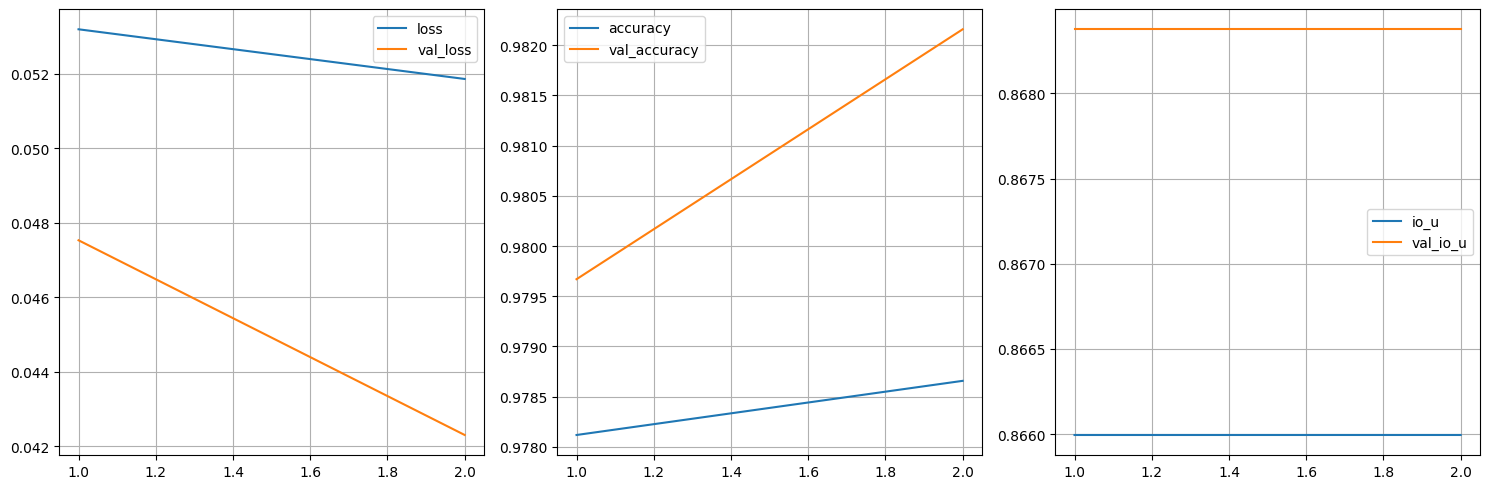

922/922 [==============================] - 43s 47ms/step - loss: 0.0519 - accuracy: 0.9787 - io_u: 0.8660 - val_loss: 0.0423 - val_accuracy: 0.9822 - val_io_u: 0.8684


In [ ]:
import nibabel as nib
view = "sagittal"

checkpointer = tf.keras.callbacks.ModelCheckpoint(f'model_for_{view}.h5', verbose=1, save_best_only=True)

callbacks = [
        #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss'),
        PlotLearning()]
        # tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = model.fit(X_train_resized, Y_train_resized, validation_split=0.1, batch_size=100, epochs=25, callbacks=callbacks)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=2, callbacks=callbacks)
# results = model.fit(dataset, batch_size=1, epochs=1, callbacks=callbacks)

# Testing the Model

(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)


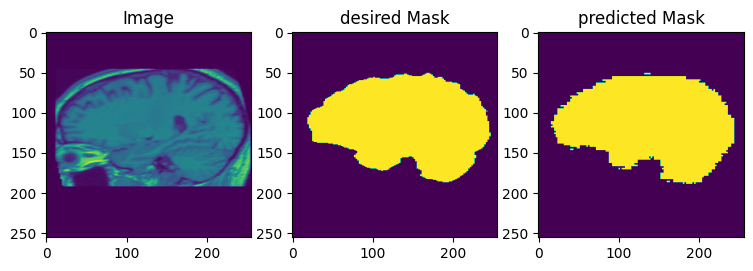

In [ ]:
import matplotlib.pyplot as plt

img = X_test[:256,:,:,:]
print(img.shape)
pred = model(img)
print(pred.shape)
mask=Y_test[:256,:,:,:]
print(mask.shape)


import random
idx = 150
plt.figure(figsize=(9,3))
plt.subplot(131), plt.imshow(np.squeeze(img[idx])), plt.title('Image')
plt.subplot(132), plt.imshow(np.squeeze(mask[idx])), plt.title('desired Mask')
a  = np.logical_and(pred[idx] > 0.45, pred[idx] < 0.48)
plt.subplot(133), plt.imshow((np.squeeze(pred[idx])>0.5)), plt.title('predicted Mask')



plt.show()

In [ ]:
converted_array=np.array(pred[:,:,:,0])

In [ ]:
import nibabel as nb

ni_img = nib.Nifti1Image(converted_array, affine=np.eye(4))
nib.save(ni_img, "mask.nii")

In [ ]:
import nibabel as nb
converted_array=np.array(img)
ni_img = nib.Nifti1Image(converted_array, affine=np.eye(4))
nib.save(ni_img, "image2.nii")

In [ ]:
final_image=np.multiply(img[:,:,:,0],converted_array)

In [ ]:
plt.imshow(final_image[150,:,:])

In [ ]:
import nibabel as nb

ni_img = nib.Nifti1Image(final_image, affine=np.eye(4))
nib.save(ni_img, "final.nii")

# AIIMS Data

In [ ]:
import nibabel as nib
img=nib.load("/content/anita_4.nii").get_fdata()

In [ ]:
img.shape

(240, 400, 400)

In [ ]:
# returns single slices of frontal view
def frontal_view_imgs(data):
  list_frontal_view_imgs = []
  for i in range(data.shape[0]):
    im_slice = data[i,:,:]
    # im_resized = im_slice
    im_resized = cv2.resize(im_slice, (256, 256))
    del im_slice
    list_frontal_view_imgs.append(np.expand_dims(im_resized, -1))

  list_frontal_view_imgs = np.array(list_frontal_view_imgs)
  return list_frontal_view_imgs

# returns single slices of side view
def side_view_imgs(data):
  list_side_view_imgs = []
  for i in range(data.shape[2]):

    im_slice = data[:,:,i]

    # im_resized = im_slice
    im_resized = cv2.resize(im_slice, (256, 256))
    del im_slice

    list_side_view_imgs.append(np.expand_dims(im_resized, -1))

  list_side_view_imgs = np.array(list_side_view_imgs)
  return list_side_view_imgs

# returns single slices of top view
def top_view_imgs(data):
  list_top_view_imgs = []
  for i in range(data.shape[1]):
      im_slice = data[:, i, :]
      # im_resized = im_slice
      im_resized =  cv2.resize(im_slice, (256, 256))
      list_top_view_imgs.append(np.expand_dims(im_resized, -1))

  list_top_view_imgs = np.array(list_top_view_imgs)
  return list_top_view_imgs

In [ ]:
front_view=frontal_view_imgs(img)
top_view=top_view_imgs(img)
side_view=side_view_imgs(img)

In [ ]:
front_view.shape

(240, 256, 256, 1)

In [ ]:
def plot_test(view):
  pred=model(view)
  idx = 190
  plt.figure(figsize=(9,3))
  plt.subplot(131), plt.imshow(np.squeeze(view[idx])), plt.title('Image')
  # plt.subplot(132), plt.imshow(np.squeeze(mask[idx])), plt.title('desired Mask')
  a  = np.logical_and(pred[idx] > 0.45, pred[idx] < 0.48)
  plt.subplot(133), plt.imshow((np.squeeze(pred[idx])>0.5)), plt.title('predicted Mask')
  plt.show()

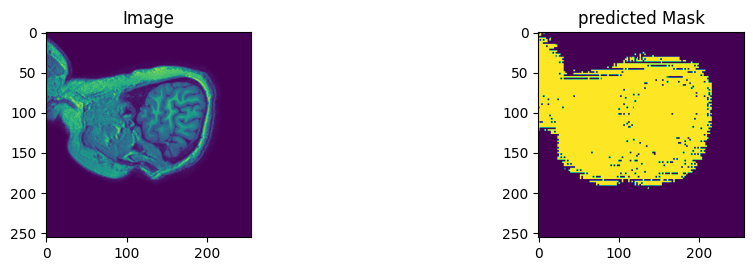

In [ ]:
plot_test(front_view)